In [1]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import os
import warnings

warnings.filterwarnings("ignore")

path = r'C:\Users\ruanv\OneDrive\Documentos\Mestrado\Projeto de Mestrado\bases'

df = pd.read_csv(os.path.join(path,'demandaTrafos_2018-2023.csv'), sep=';', encoding='latin-1')

df.rename(columns={
    'Potencia Ativa': 'P',
    'Potencia Reativa': 'Q',
    'Data/Hora Medição': 'datahora'
}, inplace=True)


# df['datahora'] = pd.to_datetime(df['datahora'], dayfirst=True).dt.strftime('%d/%m/%Y %H:%M:%S')
df['datahora'] = pd.to_datetime(df['datahora'], dayfirst=True, errors='coerce')

df['P'] = df['P'].abs()  # salvando o módulo dos valores
df['Q'] = df['Q'].abs()  # salvando o módulo dos valores

df['S'] = np.sqrt(df['P']**2 + df['Q']**2)


df = df[df['S'] != 0]

df_filtrado = pd.DataFrame()

for trafo in df['TRAFO'].unique():

    df_trafo = df[df['TRAFO'] == trafo]

    Q1 = df_trafo['S'].quantile(0.25)
    Q3 = df_trafo['S'].quantile(0.75)
    IQR = Q3 - Q1

    # Calculando limites inferior e superior
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_trafo_filtrado = df_trafo[(df_trafo['S'] >= lower_bound) & (df_trafo['S'] <= upper_bound)]

    # Adicionar os dados filtrados ao DataFrame filtrado total
    df_filtrado = pd.concat([df_filtrado, df_trafo_filtrado], ignore_index=True)

    # Adicionar os dados filtrados ao DataFrame filtrado total
    df_filtrado = pd.concat([df_filtrado, df_trafo_filtrado], ignore_index=True)


# df_filtrado['Dia'] = pd.to_datetime(df_filtrado['Dia'])
df_filtrado = df_filtrado.sort_values(by=['TRAFO', 'datahora'])

df_filtrado = df_filtrado.drop_duplicates(subset=['datahora', 'TRAFO'])


# Criando gráfico da Potência Aparente ao longo do tempo, separada por TRAFO
fig_aparente = px.line(df_filtrado, x='datahora', y='S', color='TRAFO',
                       title='Potência Aparente ao Longo do Tempo por Transformador',
                       labels={'S': 'Potência Aparente (kVA)', 'Dia': 'Data'})

# fig_aparente.show()

# fig_aparente.write_html("Demanda ao longo do tempo - IQR.html")


In [2]:
df = df_filtrado[df_filtrado['TRAFO'] == 'PTS-02T1']

df = df[['datahora', 'S']]

df = df.set_index(['datahora'])

df = df.resample('MS').max()

df.sort_index(inplace=True)

df['S'] = df['S'].interpolate()


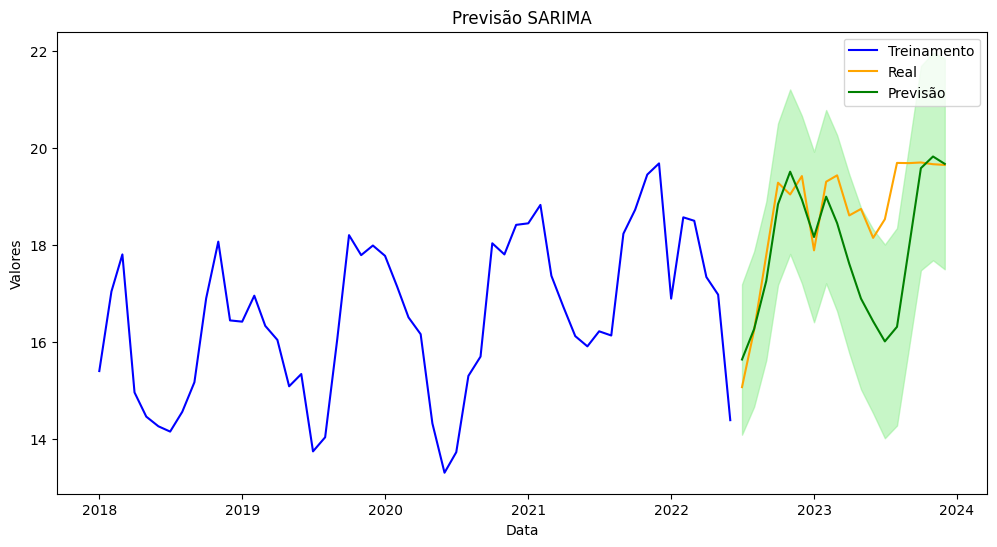

In [3]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Dividindo os dados em conjunto de treino e teste
train_size = int(len(df) * 0.75)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Ajustando o modelo SARIMA, com sazonalidade de 12 meses
model = SARIMAX(train['S'], order=(1, 1, 1), seasonal_order=(12, 1, 12, 12))
results = model.fit()

predictions = results.get_forecast(steps=len(test))
predicted_mean = predictions.predicted_mean
confidence_intervals = predictions.conf_int()

# Plot dos resultados
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['S'], label='Treinamento', color='blue')
plt.plot(test.index, test['S'], label='Real', color='orange')
plt.plot(predicted_mean.index, predicted_mean, label='Previsão', color='green')
plt.fill_between(predicted_mean.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='lightgreen', alpha=0.5)
plt.title('Previsão SARIMA')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()


Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 29s 465ms/step - loss: 0.0845
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 383ms/step - loss: 0.0093
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 347ms/step - loss: 0.0087
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 390ms/step - loss: 0.0081
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 539ms/step - loss: 0.0083
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 487ms/step - loss: 0.0086
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 497ms/step - loss: 0.0085
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 487ms/step - loss: 0.0081
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 505ms/step - loss: 0.0083
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 503ms/step - loss: 0.0074
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 330ms/step - loss: 0.0076
Epoch 12/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 321ms/step - loss: 0.0082
Epoch 13/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 321ms/step - loss: 0.0075
Epoch 14/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 483ms/step - loss: 0.0073
Epoch 15/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 

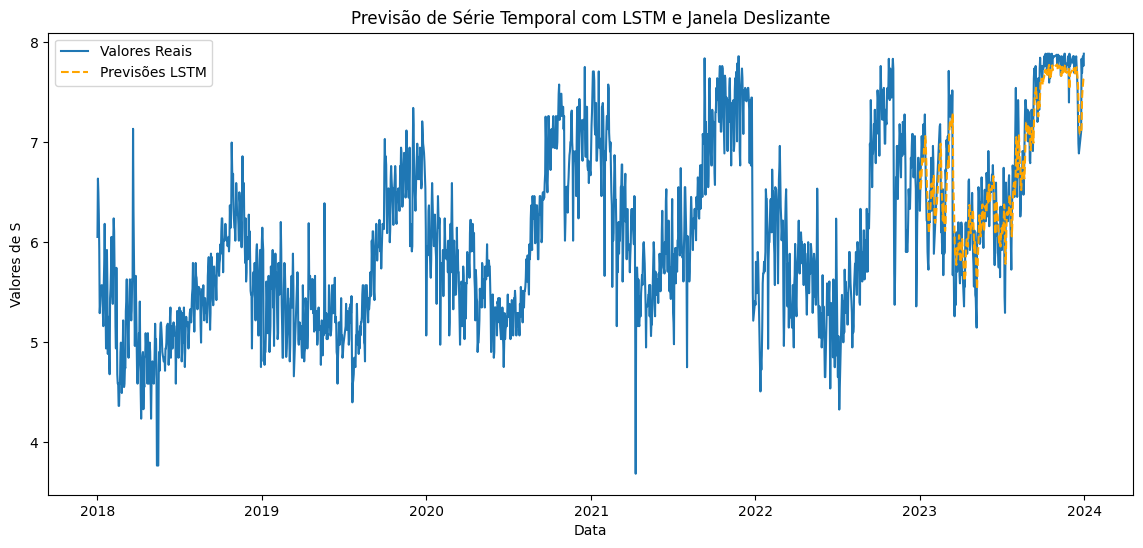

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

df = df_filtrado[df_filtrado['TRAFO'] == 'PCO-02T1']

df = df[['datahora', 'S']]

df = df.set_index(['datahora'])

df = df.resample('D').max()

df.sort_index(inplace=True)

df['S'] = df['S'].interpolate()


dados = df[['S']].values

# Normalizando os dados:
scaler = MinMaxScaler(feature_range=(0, 1))
dados_normalizados = scaler.fit_transform(dados)

# Configurações da janela deslizante. 365 dias, para capturar a sazonalidade.
janela = 365
X, y = [], []
for i in range(janela, len(dados_normalizados)):
    X.append(dados_normalizados[i-janela:i, 0])
    y.append(dados_normalizados[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Dividindo em conjunto de treino e teste. 80/20.
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Construindo o modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Fazendo previsões no conjunto de teste
y_pred_normalizado = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_normalizado)
print("Erro Quadrático Médio (MSE):", mse)

# Inversão da normalização, voltando aos valores reai
y_pred = scaler.inverse_transform(y_pred_normalizado)
y_test_inverso = scaler.inverse_transform(y_test.reshape(-1, 1))

# Ajustando o índice para os dados de previsão
df_previsoes = df.index[split + janela:]

# Visualizando os resultados
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['S'], label='Valores Reais')
plt.plot(df_previsoes, y_pred, label='Previsões LSTM', linestyle='--', color='orange')
plt.xlabel('Data')
plt.ylabel('Valores de S')
plt.title('Previsão de Série Temporal com LSTM e Janela Deslizante')
plt.legend()
plt.show()
